# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

In [3]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

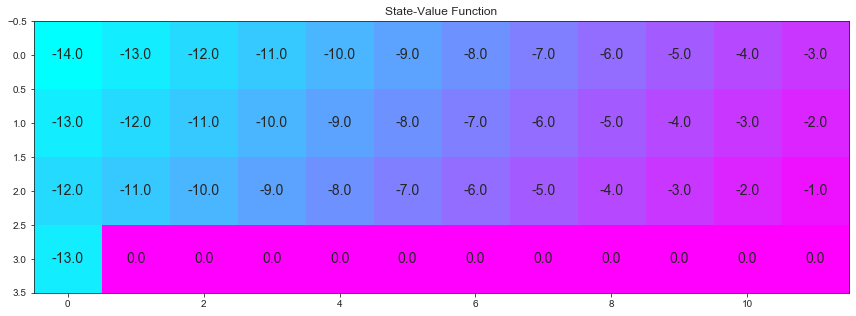

In [5]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [6]:
def get_value_TD(Q, next_state, next_action = None, TD_type = "sarsa", nA = None, epsilon = None):
    """Returns the value from the Q table based on the type of TD control algorithm"""
    if(TD_type == "sarsa"):
        return Q[next_state][next_action] if next_action is not None else 0
    elif(TD_type == "Q"):
        return np.max(Q[next_state])
    elif(TD_type == "ex_s"):
        policy_s = np.ones(nA) * epsilon / nA
        policy_s[np.argmax(Q[next_state])] = 1 - epsilon + (epsilon / nA)
        return np.dot(Q[next_state], policy_s)
    else:
        raise ValueError("Invalid TD_type specified")

In [7]:
def get_action(Q, state, eps):
    """
    Gets the action following epsilon greedy policy.
    Parameters:
    1. Q: Q-table.
    2. state: current state in the episode.
    3. eps: epsilon value following GLIE conditions.
    Returns:
    - actions: the action to take based on choosing greedy action or random action
    """
    if(np.random.random() > eps):#exploit
        return np.argmax(Q[state])
    else:
        return np.random.choice(np.arange(env.action_space.n))#explore

In [8]:
def generate_episode(env, Q, values, TD_type = "sarsa"):
    """
    Generates an episode & updates the Q_table along the way.
    Parameters:
    1. env: instance of cliffwalking env.
    2. Q: existing Q-table
    3. values: tuple of gamma, alpha, & epsilon values.
    4. TD_type: type of TD control to use. default = 'SARSA'. Options: {sarsa, Q, ex_s}. Accept as str.
    Returns:
    - Q : Updated Q table.
    - steps_to_completion: #steps it took to complete an episode.
    - total_reward: total reward accumulated during the episode.
    """
    state = env.reset() #initial state = 36
    gamma, alpha, epsilon = values #extract information
    nA = env.action_space.n #action space size.
    steps_to_completion:int = 0 #number of steps taken to task completion in one episode
    total_reward:int = 0 #total reward accumulated in an episode
    while True:
        action = get_action(Q, state, epsilon)#choose between greedy or equiprobable action
        
        next_state, reward, done,_ = env.step(action)#step into the episode
        value = Q[state][action]#get current value
        next_action = get_action(Q, next_state, epsilon)#choose between greedy or equiprobable action for next state
        
        #SARSA: Q(S0, A0) --> Q(S0, A0) + å(R1 + gamma(Q(S1, A1) - Q(S0, A0)))
        
        value += alpha*(reward + gamma*(get_value_TD(Q, next_state, next_action, TD_type, nA, epsilon) - value))
        Q[state][action] = value #update Q-table
        state = next_state #update state
        steps_to_completion += 1 #increment number of steps to episode completion
        total_reward += reward #increment reward counter
        if(done):
            break
    return Q, steps_to_completion, total_reward

In [9]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    steps_arr = []
    reward_arr = []
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        
        epsilon = 1.0/i_episode #impose GLIE conditions
        Q_updated, steps, reward = generate_episode(env, Q, (gamma, alpha, epsilon))#simulate 1 episode.
        Q = Q_updated #update value for Q-table
        #performance monitor
        steps_arr.append(steps)#append #steps for current episode (should decrease as num_episode -> ∞)
        reward_arr.append(reward)#should approach optimal reward as num_episode -> ∞
    
    #convert performance metrics to nd.array
    steps_arr = np.array(steps_arr)
    reward_arr = np.array(reward_arr)
    plt.plot(steps_arr, label="steps")#plot steps
    plt.plot(reward_arr, label="reward")#plot reward
    plt.xlabel("Number of episodes")
    plt.ylabel("Continuous value")
    plt.ylim(-300, 300)#set y-axis boundaries
    plt.legend(loc="upper right")#display legend
    plt.show()
    
    print(f"Average Reward: {reward_arr.mean()}\nAverage Steps to completion: {steps_arr.mean()}")
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

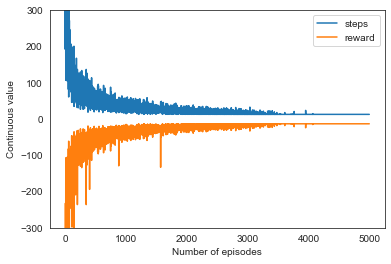

Average Reward: -33.9752
Average Steps to completion: 29.1044


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  0  1  1  0  0  1  2  2  1  2]
 [ 1  1  1  2  0  1  1  2  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


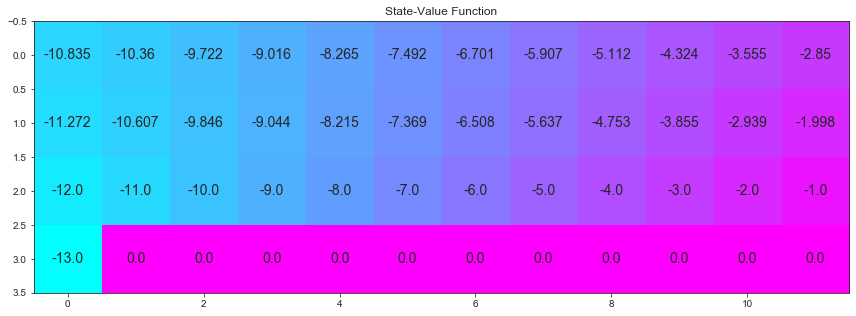

In [10]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [11]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    steps_arr = []
    reward_arr = []
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        
        epsilon = 1.0/i_episode #impose GLIE conditions
        Q_updated, steps, reward = generate_episode(env, Q, (gamma, alpha, epsilon), TD_type="Q")#simulate 1 episode.
        Q = Q_updated #update value for Q-table
        #performance monitor
        steps_arr.append(steps)#append #steps for current episode (should decrease as num_episode -> ∞)
        reward_arr.append(reward)#should approach optimal reward as num_episode -> ∞
    
    #convert performance metrics to nd.array
    steps_arr = np.array(steps_arr)
    reward_arr = np.array(reward_arr)
    plt.plot(steps_arr, label="steps")#plot steps
    plt.plot(reward_arr, label="reward")#plot reward
    plt.xlabel("Number of episodes")
    plt.ylabel("Continuous value")
    plt.ylim(-300, 300)#set y-axis boundaries
    plt.legend(loc="upper right")#display legend
    plt.show()
    
    print(f"Average Reward: {reward_arr.mean()}\nAverage Steps to completion: {steps_arr.mean()}")
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

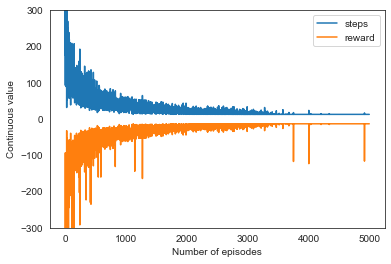

Average Reward: -35.2408
Average Steps to completion: 30.0532


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  3  1  3  1  0  1  1  0  1  2  0]
 [ 3  1  1  2  0  0  1  0  2  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


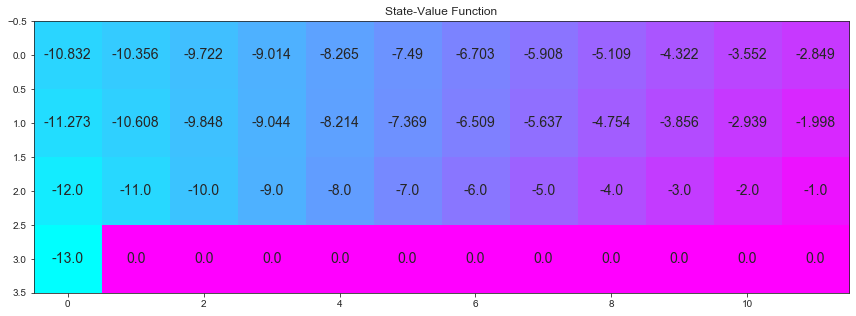

In [12]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [13]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    steps_arr = []
    reward_arr = []
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        epsilon = 0.005 #impose GLIE conditions
        Q_updated, steps, reward = generate_episode(env, Q,(gamma, alpha, epsilon), TD_type="ex_s")#simulate 1 episode
        Q = Q_updated #update value for Q-table
        #performance monitor
        steps_arr.append(steps)#append #steps for current episode (should decrease as num_episode -> ∞)
        reward_arr.append(reward)#should approach optimal reward as num_episode -> ∞
    
    #convert performance metrics to nd.array
    steps_arr = np.array(steps_arr)
    reward_arr = np.array(reward_arr)
    plt.plot(steps_arr, label="steps")#plot steps
    plt.plot(reward_arr, label="reward")#plot reward
    plt.xlabel("Number of episodes")
    plt.ylabel("Continuous value")
    plt.ylim(-300, 300)#set y-axis boundaries
    plt.legend(loc="upper right")#display legend
    plt.show()
    
    print(f"Average Reward: {reward_arr.mean()}\nAverage Steps to completion: {steps_arr.mean()}")
    print(f"Max Reward: {reward_arr.max()}")
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000

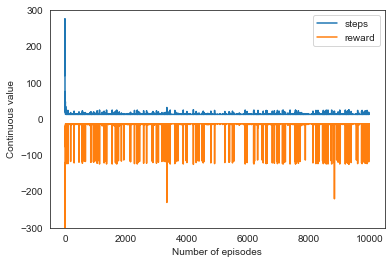

Average Reward: -14.8831
Average Steps to completion: 13.2793
Max Reward: -13


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  2  1  2  1  1  2  2]
 [ 0  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


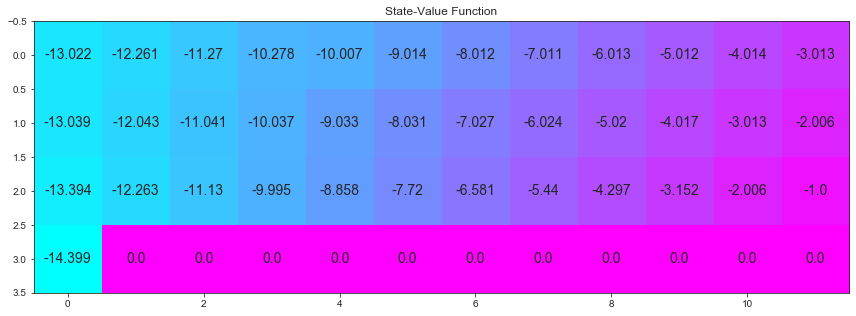

In [14]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])